In [1]:
library(BiocManager)
library(GEOquery)
library(biomaRt)
library(limma)

Bioconductor version 3.10 (BiocManager 1.30.10), ?BiocManager::install for help

Bioconductor version '3.10' is out-of-date; the current release version '3.13'
  is available with R version '4.1'; see https://bioconductor.org/install

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.

In [2]:
# biomart variables
ensembl <- useMart("ensembl")
ssalar <- useMart("ensembl", dataset="ssalar_gene_ensembl")
human <- useDataset(dataset="hsapiens_gene_ensembl", mart=ensembl)

In [3]:
# global variables
topSigGenes <- 250

In [4]:
# function to download and get DEGs
getDEG <- function(geoAccession, geoProcessor, gsms, tT_add_columns, annotation) {
    # list to return items
    qrList <- list()

    # download
    gset <- getGEO(geoAccession, GSEMatrix =TRUE, AnnotGPL=annotation)
    if (length(gset) > 1) idx <- grep(geoPlatform, attr(gset, "names")) else idx <- 1
    gset <- gset[[idx]]
    
    # make proper column names to match toptable 
    fvarLabels(gset) <- make.names(fvarLabels(gset))
    
    # group membership for all samples
    sml <- strsplit(gsms, split="")[[1]]
    
    # filter out excluded samples (marked as "X")
    sel <- which(sml != "X")
    sml <- sml[sel]
    gset <- gset[ ,sel]

    
    # auto-detect feature to determine if the values are or are not in log space 
    # if not log2 transformation
    # if qx[5] > 100 is true than at least 1% of the data is bigger than 100.
    # A value of 100 or bigger can not be the result of log transformation
    # because the reverse 2-log (2^100) is so big that you cannot even calculate it! 
    # sources biostars and GEO2R
    ex <- exprs(gset)
    qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
    LogC <- (qx[5] > 100) || (qx[6]-qx[1] > 50 && qx[2] > 0)

    if (LogC) { ex[which(ex <= 0)] <- NaN
      exprs(gset) <- log2(ex) }
    
    # assign samples to groups and set up design matrix
    gs <- factor(sml)
    groups <- make.names(c("Control","Experimental1"))
    levels(gs) <- groups
    gset$group <- gs
    design <- model.matrix(~group + 0, gset)
    colnames(design) <- levels(gs)

    fit <- lmFit(gset, design)  # fit linear model

    # set up contrasts of interest and recalculate model coefficients
    cts <- paste(groups[1], groups[2], sep="-")
    cont.matrix <- makeContrasts(contrasts=cts, levels=design)
    fit2 <- contrasts.fit(fit, cont.matrix)

    # compute statistics and table of top significant genes
    fit2 <- eBayes(fit2, 0.01)
    tT <- topTable(fit2, adjust="fdr", sort.by="B", number=250)
    
    tT_colnames <- c("ID","adj.P.Val","P.Value","t","B","logFC")
    tT_colnames <- append(tT_colnames, tT_add_columns, after = length(tT_colnames))
    tT <- subset(tT, select=tT_colnames)
    
    # Visualize and quality control test results.
    # Build histogram of P-values for all genes. Normal test
    # assumption is that most genes are not differentially expressed.
    tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
    
    hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
                                                 ylab = "Number of genes", main = "P-adj value distribution")
    
    # summarize test results as "up", "down" or "not expressed"
    dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05)

    # Venn diagram of results
    vennDiagram(dT, circle.col=palette())

    # create Q-Q plot for t-statistic
    t.good <- which(!is.na(fit2$F)) # filter out bad probes
    qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

    # volcano plot (log P-value vs log fold change)
    colnames(fit2) # list contrast names
    ct <- 1        # choose contrast of interest
    volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
      highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

    # MD plot (log fold change vs mean log expression)
    # highlight statistically significant (p-adj < 0.05) probes
    plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
    abline(h=0)
    
    return(list("gset" = gset, "gsetExprs" = exprs(gset),
                "sampleGroups" = gs, "DEGs" = subset(tT2, select=tT_colnames), "fit2" = fit2, "tT2" = tT2))
}

Found 1 file(s)

GSE122142_series_matrix.txt.gz

Using locally cached version: /tmp/Rtmpr6xrLA/GSE122142_series_matrix.txt.gz


── Column specification ───────────────────────────────────────────────────────────
cols(
  .default = col_double()
)
ℹ Use `spec()` for the full column specifications.


Using locally cached version of GPL16555 found here:
/tmp/Rtmpr6xrLA/GPL16555.soft 

Warning message:
“Duplicated column names deduplicated: 'SPOT_ID' => 'SPOT_ID_1' [9]”
Warning message:
“Partial NA coefficients for 596 probe(s)”


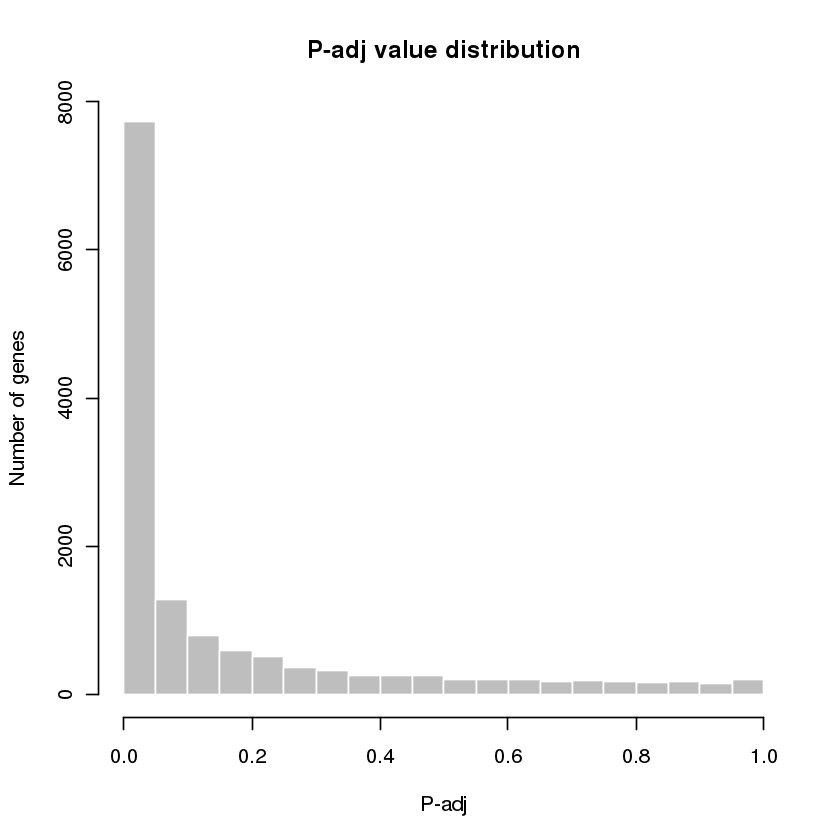

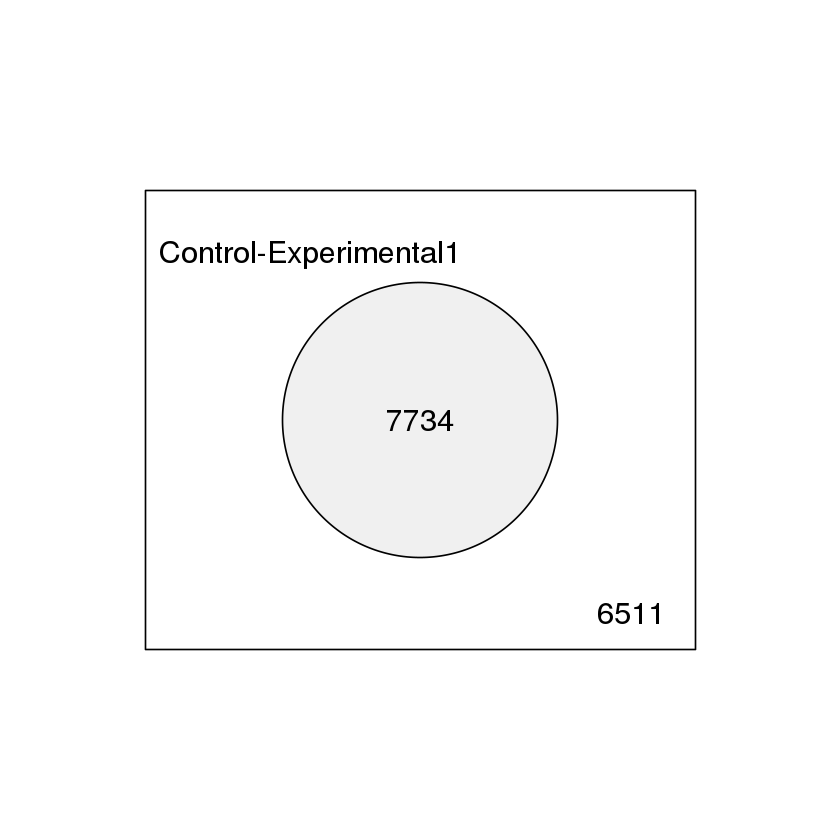

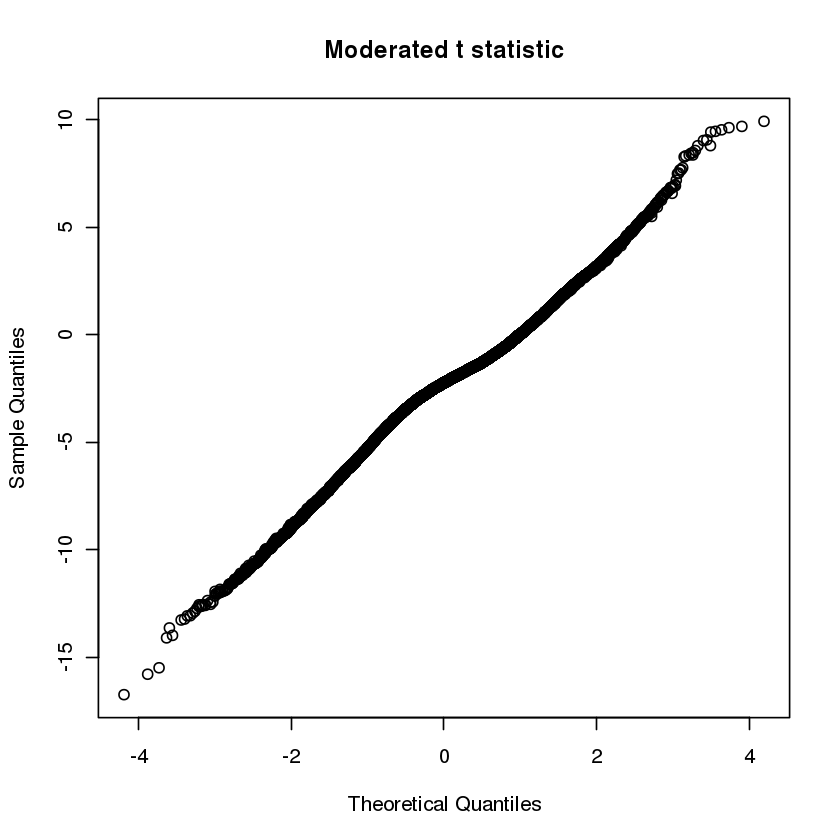

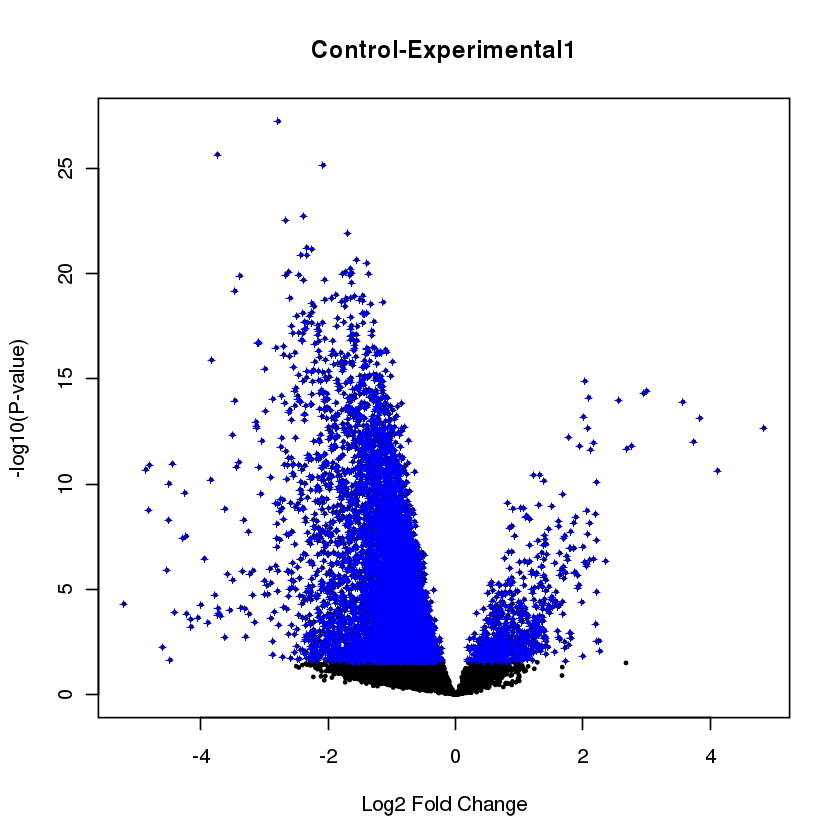

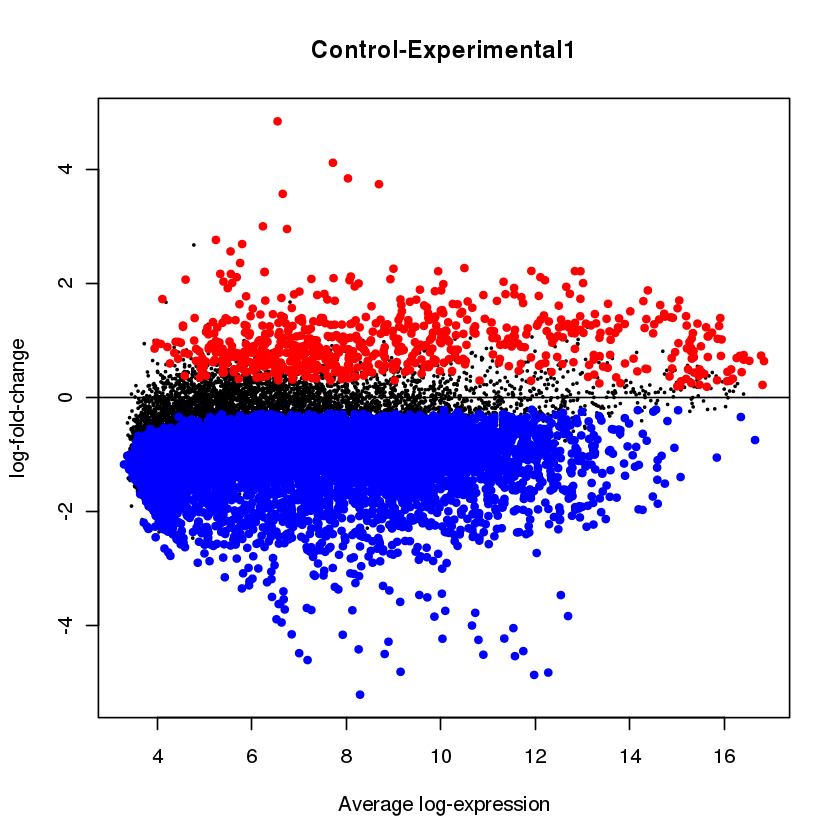

In [8]:
GSE122142_obj <- getDEG("GSE122142", "GPL16555", paste0("00000000111111111111111111111111111111111111111111",
        "11111111111111111111111111111"), c("GB_ACC","SPOT_ID","SEQUENCE"), F)

In [9]:
# access transcript definitions
print(paste("Total Transcripts:", nrow(GSE122142_obj$tT2), sep=" "))
transcriptToGene <- pData(featureData(GSE122142_obj$gset))
totalTranscripts <- transcriptToGene[as.character(GSE122142_obj$tT2$ID),]

[1] "Total Transcripts: 15377"


In [14]:
current_accessions <-totalTranscripts[totalTranscripts$GB_ACC != "",]$GB_ACC
acc<-gsub("\\.\\d", "", current_accessions)

In [23]:
salmon_genes <- getBM(attributes=c("ensembl_gene_id","hgnc_symbol","embl"), filter="embl", value=acc, mart=ssalar)

Cache found



In [21]:
nrow(salmon_genes)
head(salmon_genes)
length(acc)
head(acc)

[1] 455

,ensembl_gene_id,hgnc_symbol,embl
,<chr>,<chr>,<chr>
1,ENSSSAG00000062407,NA,AB489201
2,ENSSSAG00000068171,NA,AF542965
3,ENSSSAG00000081480,NA,AJ409288
4,ENSSSAG00000043510,NA,AJ505008
5,ENSSSAG00000081485,NA,AJ608768
6,ENSSSAG00000049319,NA,AY360357


[1] 11063

[1] "DW570665" "JT824321" "BT047234" "BT045474" "BT059565" "BT043702"